# Pylops-distributed - Marchenko redatuming with 3D dataset with multiple virtual points

### Author: M.Ravasi

This notebook applies the distributed *Marchenko* algorithm to multiple virtual points

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import zarr
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt
from scipy.spatial import Voronoi, ConvexHull, voronoi_plot_2d

from pylops.basicoperators import *
from pylops.waveeqprocessing.mdd       import MDC
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.waveeqprocessing.marchenko import directwave
from pylops.utils import dottest

from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.basicoperators import Diagonal as dDiagonal
from pylops_distributed.basicoperators import Identity as dIdentity
from pylops_distributed.basicoperators import Roll as dRoll
from pylops_distributed.waveeqprocessing.mdd import MDC as dMDC
from pylops_distributed.waveeqprocessing.marchenko import Marchenko as dMarchenko
from pylops_distributed.optimization.cg import cg as dcg
from pylops_distributed.optimization.cg import cgls as dcgls

from utils import voronoi_volumes

In [2]:
os.environ["STORE_PATH"] = "/project/fsenter/mrava/Marchenko3D/"

In [3]:
client = pylops_distributed.utils.backend.dask(hardware='multi', client='be-linrgsn123:8786')
client

Client Scheduler: tcp://be-linrgsn123:8786 Dashboard: http://be-linrgsn123:8787/status,Cluster Workers: 8 Cores: 96 Memory: 1.08 TB


In [4]:
client.restart()

Client Scheduler: tcp://be-linrgsn123:8786 Dashboard: http://be-linrgsn123:8787/status,Cluster Workers: 8 Cores: 96 Memory: 1.08 TB


In [5]:
nworkers = len(np.array(list(client.ncores().values())))
ncores = np.sum(np.array(list(client.ncores().values())))
print('Nworkers', nworkers)
print('Ncores', ncores)

Nworkers 8
Ncores 96


## Inputs

Input parameters 

In [6]:
vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 300         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
nvs = 31            # number of virtual sources
n_iter = 10         # iterations
subsampling = 4     # subsampling of src-recs compared to original data
displaygeom = False # display geometry
figclip = 1e3       # figure clip factor

inputfile_aux = os.environ["STORE_PATH"] + '3DMarchenko_auxiliary_2.npz' 
zarrfile = os.environ["STORE_PATH"] + 'input3D_sub%d_ffirst.zarr' % subsampling

Load input

In [7]:
inputdata_aux = np.load(inputfile_aux)

Read geometry

In [8]:
# Receivers
r = inputdata_aux['recs'][::subsampling].T
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata_aux['srcs'][::subsampling].T
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points (y, x, z)
vs = np.vstack((620*np.ones(nvs), np.linspace(580 - 20*(nvs//2), 580 + 20*(nvs//2), nvs), 650*np.ones(nvs)))

# Density model
rho = inputdata_aux['rho']
z, x, y = inputdata_aux['z'], inputdata_aux['x'], inputdata_aux['y']

In [9]:
vs1 = inputdata_aux['vs'] 
vs1, vs, vs[:,nvs//2]

(array([620, 580, 650]),
 array([[620., 620., 620., 620., 620., 620., 620., 620., 620., 620., 620.,
         620., 620., 620., 620., 620., 620., 620., 620., 620., 620., 620.,
         620., 620., 620., 620., 620., 620., 620., 620., 620.],
        [280., 300., 320., 340., 360., 380., 400., 420., 440., 460., 480.,
         500., 520., 540., 560., 580., 600., 620., 640., 660., 680., 700.,
         720., 740., 760., 780., 800., 820., 840., 860., 880.],
        [650., 650., 650., 650., 650., 650., 650., 650., 650., 650., 650.,
         650., 650., 650., 650., 650., 650., 650., 650., 650., 650., 650.,
         650., 650., 650., 650., 650., 650., 650., 650., 650.]]),
 array([620., 580., 650.]))

Identify areal extent of each source-receiver to be used in MDC integral

In [10]:
# find area of each volume - note that areas at the edges and on vertex are unbounded, ̈́
# we will assume that they are and use the minimum are for all points in this example
vertex, vols = voronoi_volumes(r[:2].T)
darea = np.min(np.unique(vols))
print('Integration area %f' % darea)

Integration area 900.000000


Read data

In [11]:
# time axis
ot, dt, nt = 0, 2.5e-3, 601
t = np.arange(nt)*dt

In [12]:
dRtwosided_fft = 2 * da.from_zarr(zarrfile)  # 2 * as per theory you need 2*R

In [13]:
nchunks = [max(nfmax // ncores, 1), ns, nr]
dRtwosided_fft = dRtwosided_fft.rechunk(nchunks)
dRtwosided_fft = client.persist(dRtwosided_fft)
client.rebalance(dRtwosided_fft)
dRtwosided_fft

,Array,Chunk
Bytes,14.42 GB,144.18 MB
Shape,"(300, 2451, 2451)","(3, 2451, 2451)"
Count,100 Tasks,100 Chunks
Type,complex64,numpy.ndarray


In [14]:
if displaygeom:
    Rmid_fft = (dRtwosided_fft[:, ns // 2]).compute()
    Rmid = np.fft.irfft(Rmid_fft, n=2*nt-1, axis=0)

Read wavelet to apply to subsurface fields

In [15]:
wav = ricker(t[:51], 20)[0]
wav_c = np.argmax(wav)

Visualization

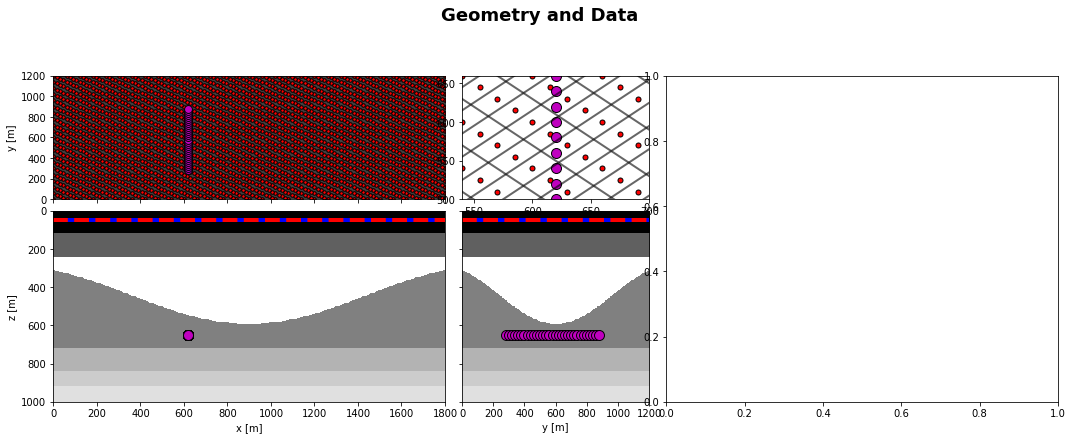

In [16]:
fig = plt.figure(figsize=(18, 6))
plt.suptitle('Geometry and Data', y=1.04, fontsize=18, fontweight='bold')
ax0 = plt.subplot2grid((5, 10), (0, 0), rowspan=2, colspan=4)
ax1 = plt.subplot2grid((5, 10), (2, 0), rowspan=3, colspan=4)
ax2 = plt.subplot2grid((5, 10), (0, 4), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((5, 10), (2, 4), rowspan=3, colspan=2)
ax4 = plt.subplot2grid((5, 10), (0, 6), rowspan=5, colspan=6)

ax0.imshow(rho[:,:,np.argmin(np.abs(z-vs1[2]))], cmap='gray', origin='lower',
           vmin=2000, vmax=6000, extent = (x[0], x[-1], y[0], y[-1]))
ax0.scatter(s[0], s[1], marker='.', s=50, c='r', edgecolors='k')
ax0.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
ax0.axis('tight')
ax0.set_ylabel('y [m]')
ax0.set_xlim(x[0], x[-1])
ax0.set_ylim(y[0], y[-1])
#ax0.text(50, 1000, '(a)', va="center", color='k', fontsize=12,
#         bbox=dict( fc='w', ec='k'))
ax0.set_xticklabels([])

ax1.imshow(rho[np.argmin(np.abs(x-vs1[1]))].T, cmap='gray', vmin=1000, vmax=5000,
           extent = (x[0], x[-1], z[-1], z[0]))
ax1.axhline(r[2, 0], color='b', lw=4)
ax1.axhline(s[2, 0], color='r', linestyle='--', lw=4)
ax1.scatter(vs[0], vs[2], marker='.', s=400, c='m', edgecolors='k')
ax1.axis('tight')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('z [m]')
ax1.set_xlim(x[0], x[-1])
#ax1.text(50, 100, '(b)', va="center", color='k', fontsize=15,
#         bbox=dict( fc='w', ec='k'))

voronoi_plot_2d(vertex, ax=ax2, show_points=False,
                show_vertices=False, line_colors='k',
                line_width=2, line_alpha=0.6, point_size=10)
ax2.scatter(s[0], s[1], marker='.', s=100, c='r', edgecolors='k')
ax2.scatter(vs[0], vs[1], marker='.', s=400, c='m', edgecolors='k')
ax2.set_xlim(vs1[0]-80, vs1[0]+80)
ax2.set_ylim(vs1[1]-80, vs1[1]+80)
#ax2.text(550, 600, '(c)', va="center", color='k', fontsize=15,
#         bbox=dict( fc='w', ec='k'))

ax3.imshow(rho[np.argmin(np.abs(y-vs1[0]))].T, cmap='gray', vmin=1000, vmax=5000,
           extent = (y[0], y[-1], z[-1], z[0]))
ax3.axhline(r[2, 0], color='b', lw=4)
ax3.axhline(s[2, 0], color='r', linestyle='--', lw=4)
ax3.scatter(vs[1], vs[2], marker='.', s=400, c='m', edgecolors='k')
ax3.set_xlabel('y [m]')
ax3.axis('tight')
ax3.set_xlim(y[0], y[-1]);
ax3.set_yticklabels([])
#ax3.text(100, 100, '(d)', va="center", color='k', fontsize=15,
#         bbox=dict( fc='w', ec='k'))

if displaygeom:
    ax4.imshow(Rmid[nt:], cmap='gray', vmin=-1e-5, vmax=1e-5, extent=(0, nr, t[-1], t[0]))
    ax4.axis('tight')
    ax4.set_xlim(nr//2-400, nr//2+400)
    ax4.set_xlabel('# Rec')
    ax4.set_ylabel('t [s]')
    ax4.set_ylim(0.8, 0.)
    #ax4.text(1130, 0.05, '(f)', va="center", color='k', fontsize=15,
    #         bbox=dict( fc='w', ec='k'))

    plt.tight_layout()
    #plt.savefig('Figures/geometry_subsampling%d.eps' % subsampling, bbox_inches='tight')
    plt.savefig('Figures/geometry_subsampling%d.png' % subsampling, dpi=300, bbox_inches='tight')

## Marchenko preparation

Create window

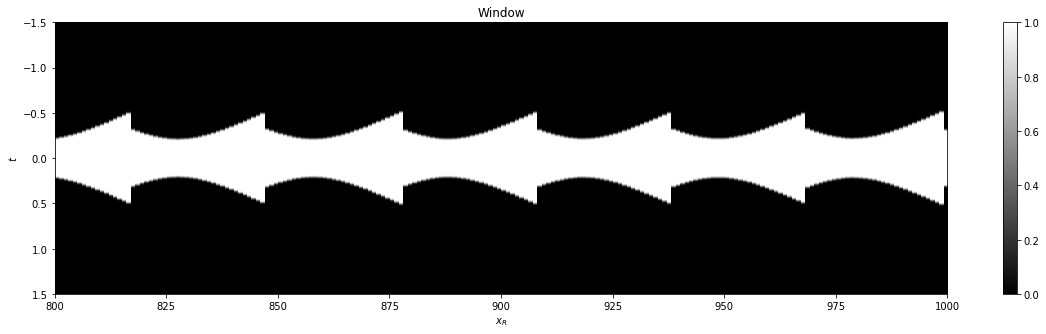

In [17]:
# direct arrival window - traveltime
distVS = np.sqrt((vs[0]-r[0][:, np.newaxis])**2 +
                 (vs[1]-r[1][:, np.newaxis])**2 +
                 (vs[2]-r[2][:, np.newaxis])**2)
directVS = distVS/vel
directVS_off = directVS - toff

# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nvs, nt))
for ir in range(nr):
    for ivs in range(nvs):
        w[ir, ivs, :idirectVS_off[ir, ivs]]=1            
w = np.concatenate((np.flip(w, axis=-1), w[:,:, 1:]), axis=-1)
if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
    
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(20, 5))
im = ax.imshow(w.transpose(1, 0, 2).reshape(nr*nvs, 2*nt-1).T, cmap='gray', 
               extent=(0, nr*nvs, t[-1], -t[-1]))
ax.set_title('Window') 
ax.set_xlabel(r'$x_R$')
ax.set_ylabel(r'$t$')
ax.axis('tight')
ax.set_xlim(800, 1000);
fig.colorbar(im, ax=ax);

Create analytical direct wave

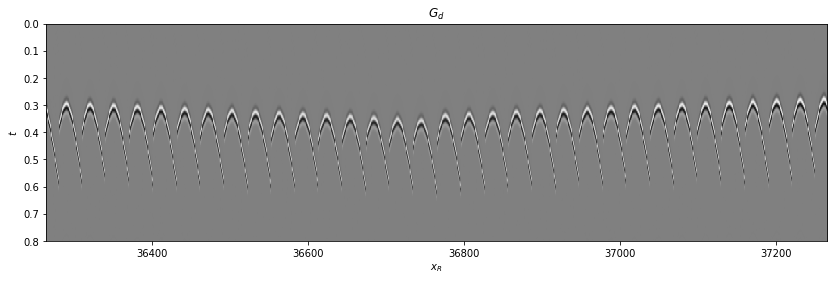

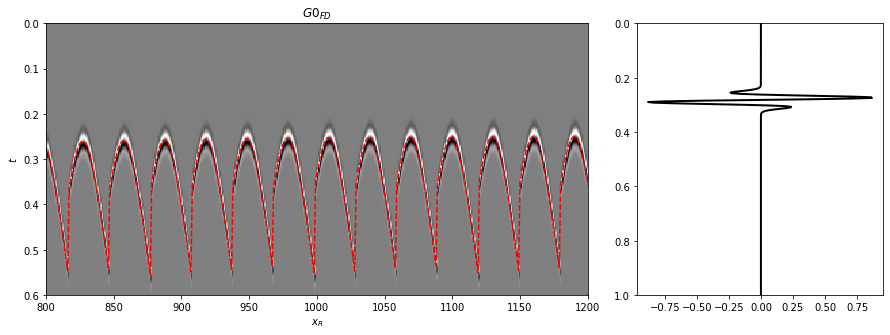

In [18]:
G0sub = np.zeros((nr, nvs, nt))
for ivs in range(nvs):
    G0sub[:, ivs] = directwave(wav, directVS[:,ivs], nt, dt, nfft=2**11, dist=distVS[:,ivs], kind='3d').T
    
# differentiate to get same as FD modelling
G0sub = np.diff(G0sub, axis=-1)
G0sub = np.concatenate([G0sub, np.zeros((nr, nvs, 1))], axis=-1)

# normalize
G0submax = np.max(G0sub)
G0sub = G0sub * (12719.769055041654 / G0submax) # to have same amplitude as in Marchenko3D example

fig, ax = plt.subplots(figsize=(14, 4))
ax.imshow(G0sub.transpose(1, 0, 2).reshape(nr*nvs, nt).T/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
          interpolation=None, extent=(0, nr*nvs, t[-1], 0))
ax.set_title(r'$G_d$')
ax.set_xlabel(r'$x_R$')
ax.set_ylabel(r'$t$')
ax.axis('tight')
ax.set_ylim(0.8, 0)
ax.set_xlim(nvs//2*nr-500, nvs//2*nr+500);

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))

ax1.imshow(G0sub[:, nvs//2].T / G0sub[:, nvs//2].max(), 
           cmap='gray', vmin=-1, vmax=1, 
           extent=(0, nr, t[-1], t[0]))
ax1.set_title(r'$G0_{FD}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.plot(np.arange(0, nr), directVS[:, nvs//2], '--r')
ax1.axis('tight')
ax1.set_ylim(.6, 0)
ax1.set_xlim(800, 1200)
ax2.plot(G0sub[nr//2-10, nvs//2]/G0sub.max(), t, 'k', lw=2)
ax2.set_ylim(1., 0);

## Inversion

Create distributed Marchenko operator

# Operators
dRop = dMDC(dRtwosided_fft, nt=2*nt-1, nv=nvs, dt=dt, dr=darea, twosided=True,
            saveGt=False)
dR1op = dMDC(dRtwosided_fft, nt=2*nt-1, nv=nvs, dt=dt, dr=darea, twosided=True, 
             saveGt=False, conj=True)
dRollop = dRoll((2*nt-1) * nr * nvs,
               dims=(2*nt-1, nr, nvs),
               dir=0, shift=-1)

# Input focusing function
fd_plus = np.concatenate((np.flip(G0sub, axis=-1).transpose(2, 0, 1),
                                  np.zeros((nt - 1, nr, nvs))))
dfd_plus = da.from_array(fd_plus).rechunk(fd_plus.shape)

dfd_plus

dw = da.from_array(w.transpose(2, 0, 1).flatten())
dw = dw.rechunk(dw.size)
dWop = dDiagonal(dw)
dIop = dIdentity(nr*nvs*(2*nt-1))

dMop = pylops_distributed.VStack([pylops_distributed.HStack([dIop, -1*dWop*dRop]),
                                 pylops_distributed.HStack([-1*dWop*dRollop*dR1op, dIop])])*pylops_distributed.BlockDiag([dWop, dWop])
dGop = pylops_distributed.VStack([pylops_distributed.HStack([dIop, -1*dRop]),
                                 pylops_distributed.HStack([-1*dRollop*dR1op, dIop])])

#ddottest(dGop, 2*nr*nvs*(2*nt-1), 2*nr*nvs*(2*nt-1), chunks=(2*nr*nvs*(2*nt-1), 2*nr*nvs*(2*nt-1)), verb=True)
#ddottest(dMop, 2*nr*nvs*(2*nt-1), 2*nr*nvs*(2*nt-1), chunks=(2*nr*nvs*(2*nt-1), 2*nr*nvs*(2*nt-1)), verb=True);

dp0_minus = dRop * dfd_plus.flatten()
dp0_minus = dp0_minus.reshape((2*nt-1), nr, nvs)

dp0_minus

p0_minus = dp0_minus.compute()

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(16, 6))
ax.imshow(p0_minus[..., nvs//2], cmap='gray', vmin=-6e3, vmax=6e3,
              extent=(0, nr, t[-1], -t[-1]))
ax.axis('tight')
ax.set_xlim(nr//2-100,nr//2+100)
ax.set_ylim(1, -1);

dd = dWop * dRop * dfd_plus.flatten()
dd = da.concatenate((dd.reshape(2*nt-1, nr, nvs), da.zeros((2*nt-1, nr, nvs))))
dd = dd.rechunk(dd.shape)

df1_inv = dcgls(dMop, dd.ravel(), niter=n_iter, tol=0, client=client)[0]
df1_inv = df1_inv.reshape(2*(2*nt-1), nr, nvs)

df1_inv_tot = df1_inv + da.concatenate((da.zeros((2*nt-1, nr, nvs)), 
                                        dfd_plus))

dg_inv = dGop * df1_inv_tot.flatten()
dg_inv = dg_inv.reshape(2*(2*nt-1), nr, nvs)

dd, dp0_minus, df1_inv_tot, dg_inv = \
    da.compute(dd, dp0_minus, df1_inv_tot, dg_inv)

dg_inv = np.real(dg_inv)

df1_inv_minus, df1_inv_plus = df1_inv_tot[:(2*nt-1)], df1_inv_tot[(2*nt-1):]
dg_inv_minus, dg_inv_plus = -dg_inv[:(2*nt-1)], np.flip(dg_inv[(2*nt-1):], axis=0)
dg_inv_tot = dg_inv_minus + dg_inv_plus

Using the function

In [19]:
MarchenkoWM = dMarchenko(dRtwosided_fft, nt=nt, dt=dt, dr=darea, wav=wav,
                         toff=toff, nsmooth=nsmooth, saveRt=False)

In [20]:
df1_inv_minus, df1_inv_plus, dp0_minus, dg_inv_minus, dg_inv_plus = \
    MarchenkoWM.apply_multiplepoints(directVS, G0=G0sub, nfft=2**11, rtm=True, greens=True,
                                     dottest=False, **dict(niter=n_iter, tol=0, client=client))
dg_inv_tot = dg_inv_minus + dg_inv_plus

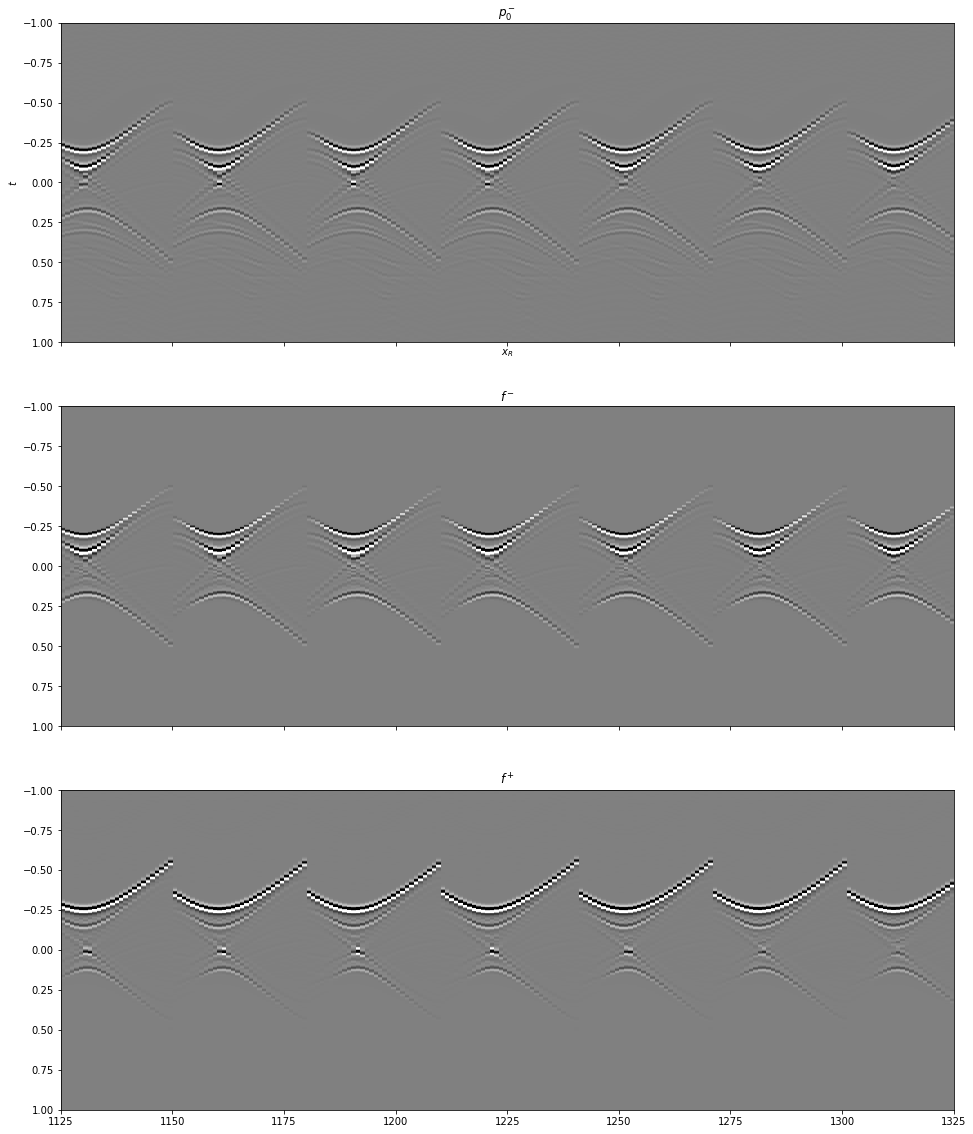

In [21]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(16, 20))
axs[0].imshow(dp0_minus[:,nvs//2].T, cmap='gray', vmin=-6*figclip, vmax=6*figclip,
              extent=(0, nr, t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(df1_inv_minus[:,nvs//2].T, cmap='gray', 
              vmin=-6*figclip, vmax=6*figclip, extent=(0, nr, t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(df1_inv_plus[:,nvs//2].T, cmap='gray', 
              vmin=-6*figclip, vmax=6*figclip, extent=(0, nr, t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[2].set_xlim(nr//2-100,nr//2+100);

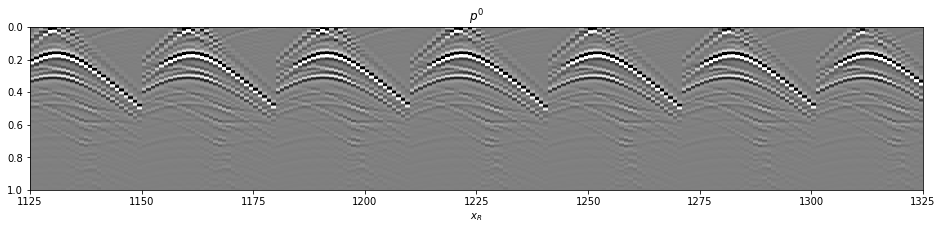

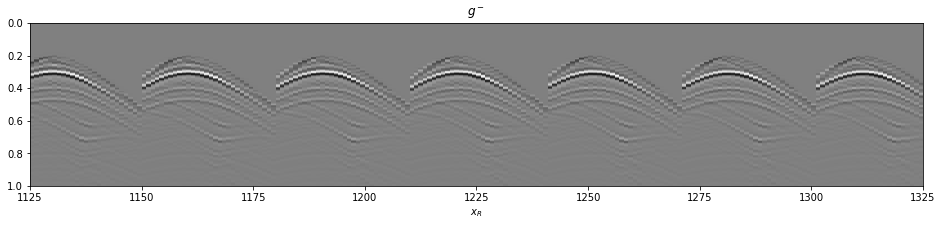

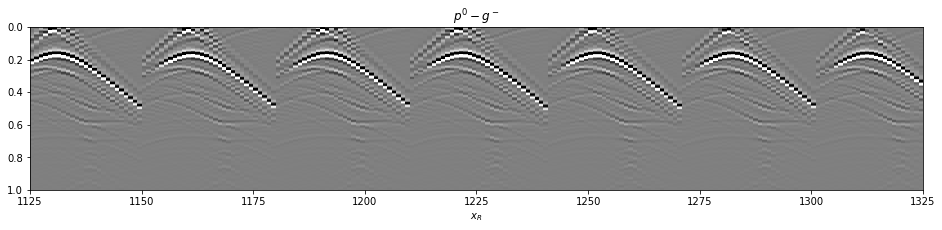

In [22]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(16, 3))
ax.imshow(dp0_minus[:, nvs//2].T,
          cmap='gray', vmin=-figclip, vmax=figclip, 
          extent=(0, nr, t[-1], -t[-1]))
ax.set_title(r'$p^0$'), ax.set_xlabel(r'$x_R$')
ax.axis('tight')
ax.set_ylim(1., 0)
ax.set_xlim(nr//2-100,nr//2+100)

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.imshow((dg_inv_minus * (1-w))[:, nvs//2].T,
          cmap='gray', vmin=-figclip, vmax=figclip, 
          extent=(0, nr, t[-1], -t[-1]))
ax.set_title(r'$g^-$'), ax.set_xlabel(r'$x_R$')
ax.axis('tight')
ax.set_ylim(1., 0)
ax.set_xlim(nr//2-100,nr//2+100)

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.imshow(dp0_minus[:, nvs//2].T - dg_inv_minus[:, nvs//2].T,
          cmap='gray', vmin=-figclip, vmax=figclip, 
          extent=(0, nr, t[-1], -t[-1]))
ax.set_title(r'$p^0 - g^-$'), ax.set_xlabel(r'$x_R$')
ax.axis('tight')
ax.set_ylim(1., 0)
ax.set_xlim(nr//2-100,nr//2+100);

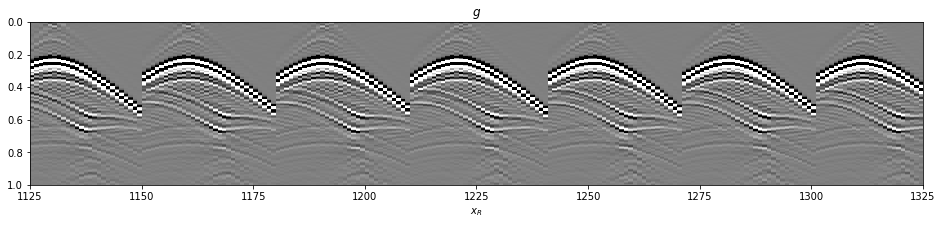

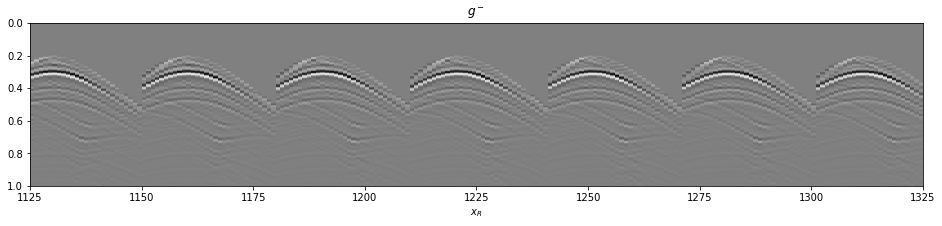

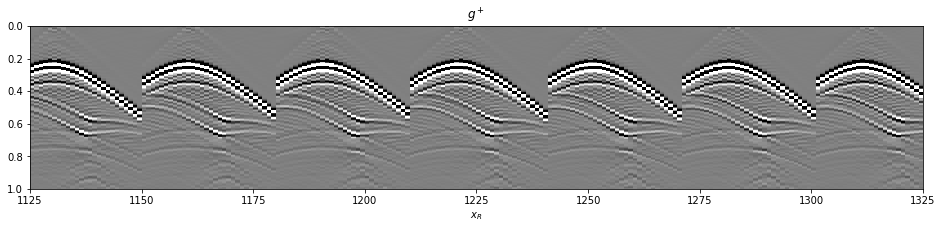

In [23]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(16, 3))
ax.imshow(dg_inv_tot[:, nvs//2].T,
          cmap='gray', vmin=-figclip, vmax=figclip, 
          extent=(0, nr, t[-1], -t[-1]))
ax.set_title(r'$g$'), ax.set_xlabel(r'$x_R$')
ax.axis('tight')
ax.set_ylim(1., 0)
ax.set_xlim(nr//2-100,nr//2+100)

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.imshow(-(dg_inv_minus * (1-w))[:, nvs//2].T,
          cmap='gray', vmin=-figclip, vmax=figclip, 
          extent=(0, nr, t[-1], -t[-1]))
ax.set_title(r'$g^-$'), ax.set_xlabel(r'$x_R$')
ax.axis('tight')
ax.set_ylim(1., 0)
ax.set_xlim(nr//2-100,nr//2+100)

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.imshow(dg_inv_plus[:, nvs//2].T,
          cmap='gray', vmin=-figclip, vmax=figclip, 
          extent=(0, nr, t[-1], -t[-1]))
ax.set_title(r'$g^+$'), ax.set_xlabel(r'$x_R$')
ax.axis('tight')
ax.set_ylim(1., 0)
ax.set_xlim(nr//2-100,nr//2+100);

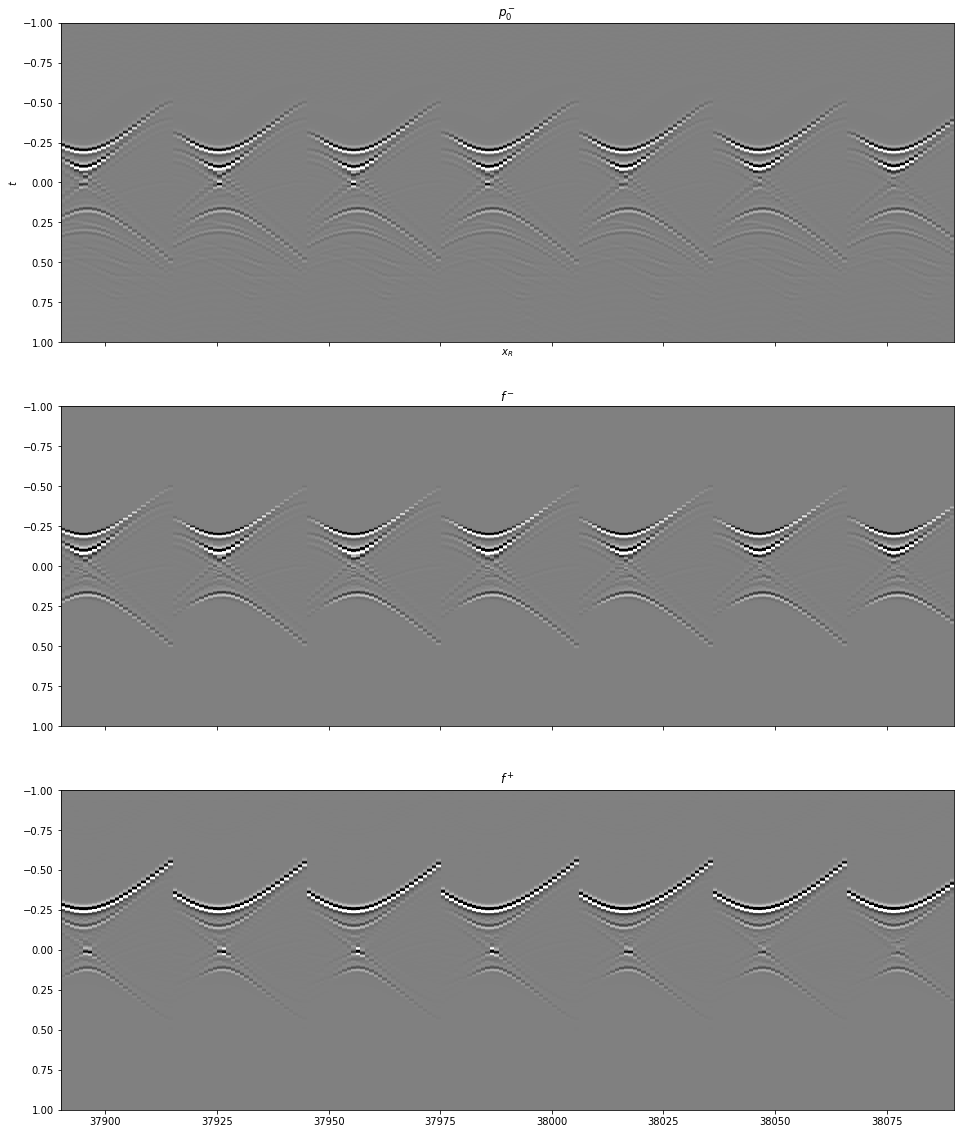

In [29]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(16, 20))
axs[0].imshow(np.swapaxes(dp0_minus, 0, 1).reshape(nr*nvs, 2*nt-1).T, cmap='gray', 
              vmin=-6*figclip, vmax=6*figclip, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(np.swapaxes(df1_inv_minus, 0, 1).reshape(nr*nvs,2*nt-1).T, cmap='gray', 
              vmin=-6*figclip, vmax=6*figclip, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(np.swapaxes(df1_inv_plus, 0, 1).reshape(nr*nvs,2*nt-1).T, cmap='gray', 
              vmin=-6*figclip, vmax=6*figclip, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[2].set_xlim(nvs*nr//2-100, nvs*nr//2+100);

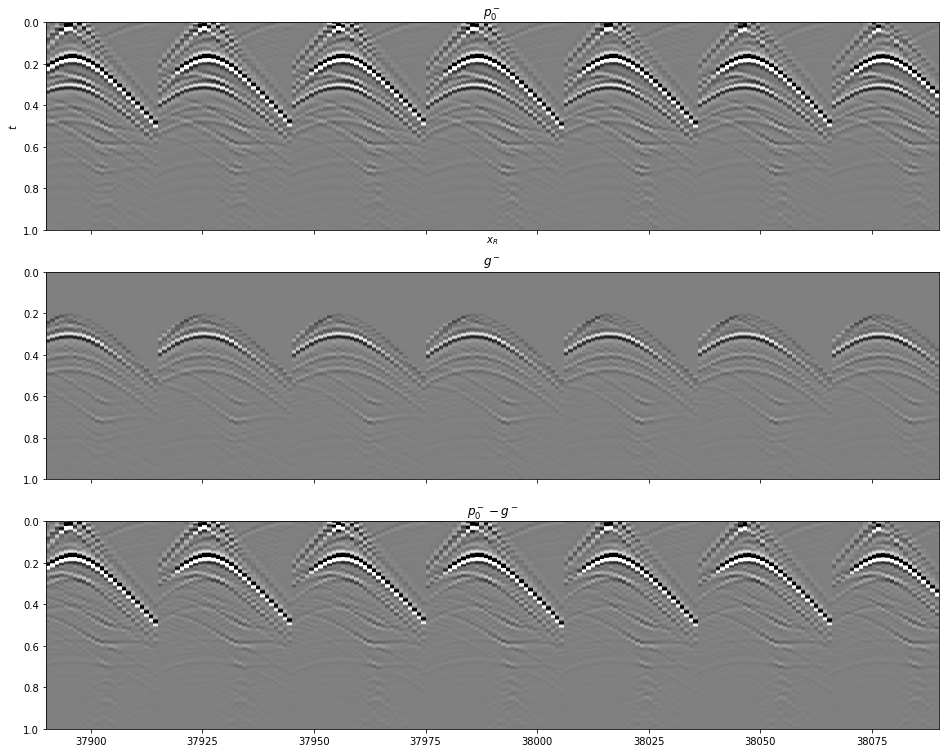

In [28]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(16, 13))
axs[0].imshow(np.swapaxes(dp0_minus, 0, 1).reshape(nr*nvs, 2*nt-1).T, cmap='gray', 
              vmin=-1*figclip, vmax=1*figclip, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, 0);
axs[1].imshow(np.swapaxes(dg_inv_minus*(1-w), 0, 1).reshape(nr*nvs,2*nt-1).T, cmap='gray', 
              vmin=-1*figclip, vmax=1*figclip, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, 0);
axs[2].imshow(np.swapaxes(dp0_minus-dg_inv_minus*(1-w), 0, 1).reshape(nr*nvs,2*nt-1).T, 
              cmap='gray', vmin=-1*figclip, vmax=1*figclip, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[2].set_title(r'$p_0^- - g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, 0);
axs[2].set_xlim(nvs*nr//2-100, nvs*nr//2+100);

In [ ]:
client.close()